# Import Library

In [42]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re
from sklearn.model_selection import train_test_split
# Cleaning Text
from bs4 import BeautifulSoup as bs
import emoji
import string
# Graph
import matplotlib.pyplot as plt
# Data Preprocessing
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords

# Data Loading

In [43]:
data = pd.read_csv('text.csv')
data.drop_duplicates(inplace=True)
data.drop(columns='Unnamed: 0', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


### Remove contradict texts

In [44]:
error = data.groupby('text').filter(lambda x: x['label'].nunique() > 1)
error.head()

,text,label
0,i just feel really helpless and heavy hearted,4
8,im forever taking some time out to have a lie ...,5
28,when,3
34,i was less intelligent and could not really fe...,2
56,i went from feeling like i knew what i was doi...,0


In [45]:
error.query('text == "i just feel really helpless and heavy hearted"')

,text,label
0,i just feel really helpless and heavy hearted,4
330710,i just feel really helpless and heavy hearted,0


In [46]:
data.drop(error.index,inplace=True)
data.groupby('text').filter(lambda x: x['label'].nunique() > 1)

,text,label


### Remove HTML Tags

In [47]:
def remove_html_tags(text):
    soup=bs(text,'html.parser')
    return soup.get_text()
data['text']=data['text'].apply(remove_html_tags)
data.head()

,text,label
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4
5,i was beginning to feel quite disheartened,0


### Remove URL Tags

In [48]:
def remove_urls(text):
    return re.sub(r'http\S+|www\S+','',text)
data['text']=data['text'].apply(remove_urls)
data.head()

,text,label
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4
5,i was beginning to feel quite disheartened,0


### Remove Punctuation

In [49]:
punctuation = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('','',punctuation))
data['text']=data['text'].apply(remove_punctuation)
data.head()

,text,label
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4
5,i was beginning to feel quite disheartened,0


### Handling Abbreviations

In [50]:
#handling abbreviations
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [51]:
def replace_chat_words(text):
    words=text.split()
    for i, word in enumerate(words):
        if word.upper() in chat_words:
            words[i]=chat_words[word.upper()].lower()
    return ' '.join(words)
data['text']=data['text'].apply(replace_chat_words)
data.head()

,text,label
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4
5,i was beginning to feel quite disheartened,0


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 372159 entries, 1 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    372159 non-null  object
 1   label   372159 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 8.5+ MB


# EDA

In [53]:
eda = data.copy()
eda['label'] = eda['label'].map({
    0: 'Sadness',
    1: 'Joy',
    2: 'Love',
    3: 'Anger',
    4: 'Fear',
    5: 'Surprise'
})

### See The Variation of Target

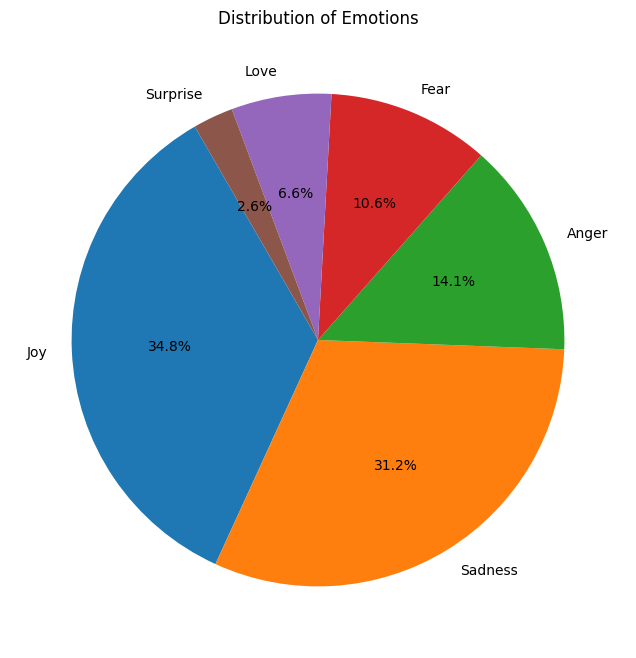

In [54]:
#import matplotlib.pyplot as plt
label_counts=eda['label'].value_counts()
plt.figure(figsize=(8,8))
plt.pie(label_counts,labels=label_counts.index,autopct='%1.1f%%',startangle=120)
plt.title('Distribution of Emotions')
plt.show()

### See Length of Suprise Classification

In [55]:
len(eda.query('label == "Surprise"'))

9839

### See Length of Joy Classification

In [56]:
len(eda.query('label == "Joy"'))

129645

### See Sample of Each Classification

In [57]:
for i in eda['label'].unique():
    print('='*10,i,'='*10)
    print(eda.query('label == "%s"'%i)['text'].head(1))

========== Sadness ==========
1    ive enjoyed being able to slouch about relax a...
Name: text, dtype: object
========== Fear ==========
2    i gave up my internship with the dmrg and am f...
Name: text, dtype: object
========== Love ==========
6    i would think that whomever would be lucky eno...
Name: text, dtype: object
========== Joy ==========
7    i fear that they won t ever feel that deliciou...
Name: text, dtype: object
========== Anger ==========
13    i feel like a jerk because the library student...
Name: text, dtype: object
========== Surprise ==========
116    i really love reading bible because i can feel...
Name: text, dtype: object


# Model Definition

In [58]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [59]:
stopwords

<WordListCorpusReader in 'C:\\Users\\Administrator\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>

In [60]:
def simple_model(input):
    keras.backend.clear_session()
    keras.utils.set_random_seed(42)
    
    model = keras.Sequential([
        keras.layers.Embedding(10000, 16,input_shape=input.shape[1:], embeddings_initializer='uniform'),
        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(6, activation='softmax')
    ])

    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    model.summary()
    return model

In [106]:
def word_processing(input):
    stopword = stopwords.words('english')
    stopword = list(set([i.replace('\'',' ').lower() for i in stopword]))
    lemme = nltk.stem.WordNetLemmatizer()
    
    output = input.apply(lambda x: ' '.join([i for i in x.split() if i not in stopword]))
    stopword = [i.replace(' ','') for i in stopword]
    
    output = output.apply(lambda x: ' '.join([i for i in x.split() if i not in stopword]))
    output = output.apply(lambda x: ' '.join([i for i in x.split() if i not in stopword]))
    
    output = output.apply(lambda x: ' '.join([lemme.lemmatize(i) for i in x.split()]))

    output = output.apply(lambda x: nltk.tokenize.word_tokenize(x))

    output = output.apply(lambda x: [str(i) for i in x])

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(output)

    maxlen = max(len(i) for i in tokenizer.texts_to_sequences(input))

    output = pad_sequences(tokenizer.texts_to_sequences(output), maxlen=maxlen, padding='post')

    output = output[...,np.newaxis]

    return output


In [107]:
reference = {j:i for i,j in enumerate(eda['label'].unique())}
reference

{'Sadness': 0, 'Fear': 1, 'Love': 2, 'Joy': 3, 'Anger': 4, 'Surprise': 5}

In [108]:
X = word_processing(eda['text'])

y = eda['label'].apply(lambda x: reference[x]).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


# Model Training

In [109]:
X_train

array([[[   4],
        [ 300],
        [ 672],
        ...,
        [   0],
        [   0],
        [   0]],

       [[ 551],
        [6620],
        [ 274],
        ...,
        [   0],
        [   0],
        [   0]],

       [[ 297],
        [ 189],
        [   2],
        ...,
        [   0],
        [   0],
        [   0]],

       ...,

       [[2187],
        [  32],
        [  67],
        ...,
        [   0],
        [   0],
        [   0]],

       [[   2],
        [1195],
        [ 677],
        ...,
        [   0],
        [   0],
        [   0]],

       [[   2],
        [ 233],
        [  39],
        ...,
        [   0],
        [   0],
        [   0]]])

In [110]:
nltk.tokenize.word_tokenize

<function nltk.tokenize.word_tokenize(text, language='english', preserve_line=False)>

In [111]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [120]:
def rnn_model(inputs):
    ##hyper parameters
    batch_size = 32
    embedding_dims = 300 #Length of the token vectors
    filters = 250 #number of filters in your Convnet
    kernel_size = 2 # a window size of 3 tokens
    hidden_dims = 250 #number of neurons at the normal feedforward NN
    epochs = 2

    model = keras.Sequential([
        keras.layers.Conv1D(filters,kernel_size,padding = 'valid' , activation = 'relu',strides = 1 , input_shape = inputs.shape[1:]),
        keras.layers.GlobalMaxPooling1D(),
        keras.layers.Dense(hidden_dims),
        keras.layers.Dropout(0.2),
        keras.layers.Activation('relu'),
        keras.layers.Dense(1),
        keras.layers.Dense(6, activation='softmax')
    ])

    model.compile(optimizer='adamw',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    model.summary()
    return model

In [121]:
type(X_train)

numpy.ndarray

In [122]:
type(X_train)

numpy.ndarray

In [127]:
X_train.shape

(238181, 111, 1)

In [123]:
model = rnn_model(X_train)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)               │ (None, 109, 250)       │         1,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_7          │ (None, 250)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 250)            │        62,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │           251 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 6)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,013 (250.05 KB)

 Trainable params: 64,013 (250.05 KB)

 Non-trainable params: 0 (0.00 B)

In [124]:
X_test.shape

(74432, 111, 1)

In [125]:
history = model.fit(X_train, y_train, epochs=10,validation_data=(X_val, y_val))

Epoch 1/10


7444/7444 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.3355 - loss: 6.1135 - val_accuracy: 0.3487 - val_loss: 1.5196
Epoch 2/10
7444/7444 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.3481 - loss: 1.5292 - val_accuracy: 0.3487 - val_loss: 1.5197
Epoch 3/10
7444/7444 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.3480 - loss: 1.5202 - val_accuracy: 0.3487 - val_loss: 1.5196
Epoch 4/10
7444/7444 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.3486 - loss: 1.5246 - val_accuracy: 0.3487 - val_loss: 1.5197
Epoch 5/10
7444/7444 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.3500 - loss: 1.5220 - val_accuracy: 0.3487 - val_loss: 1.5197
Epoch 6/10
7444/7444 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.3484 - loss: 1.5212 - val_accuracy: 0.3487 - val_loss: 1.5197
Epoch 7/10
7444/7444 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.3488 - loss: 1.5204 - val_accuracy: 0.3487 - val_loss: 1.5197
Epoch 8/10
7444/7444 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.3477 - loss: 1.5207 - val

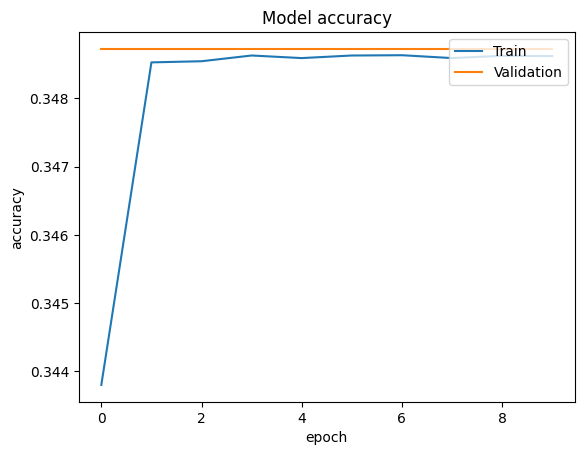

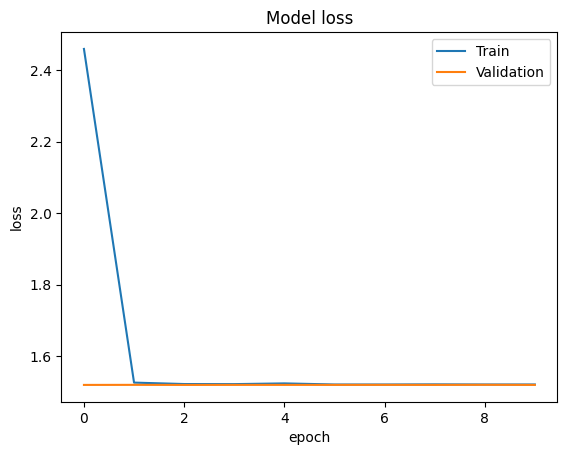

In [128]:


#import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Validation'],loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Validation'],loc='upper right')
plt.show()

